# 本项目对全球新冠病毒确诊数据进行分析，建立时间序列模型对新增确诊数量进行预测分析；数据时间跨度为2020年1月22日至2020年3月26日，一共65天。

In [1]:
# 引用包
import pandas as pd
import numpy as np
import time
import datetime
import math
import matplotlib.pyplot as plt
import statsmodels.regression.linear_model as sm
import statsmodels.api as sm 
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima_model import ARIMA
# 忽略版本问题
import warnings
warnings.filterwarnings("ignore")  

In [2]:
# 读取数据
df=pd.read_csv(r'ncov_data0.csv')
df.head()

,Province/State,Country/Region,Lat,Long,20/1/22,20/1/23,20/1/24,20/1/25,20/1/26,20/1/27,...,20/3/17,20/3/18,20/3/19,20/3/20,20/3/21,20/3/22,20/3/23,20/3/24,20/3/25,20/3/26
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,22,22,22,24,24,40,40,74,84,94
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,55,59,64,70,76,89,104,123,146,174
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,60,74,87,90,139,201,230,264,302,367
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,39,39,53,75,88,113,133,164,188,224
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,0,0,0,1,2,2,3,3,3,4


In [3]:
# 设定训练集和预测集开始和结束的日期
start_date='20200122'
end_date='20200321'
s_date='20200322'
p_date='20200326'

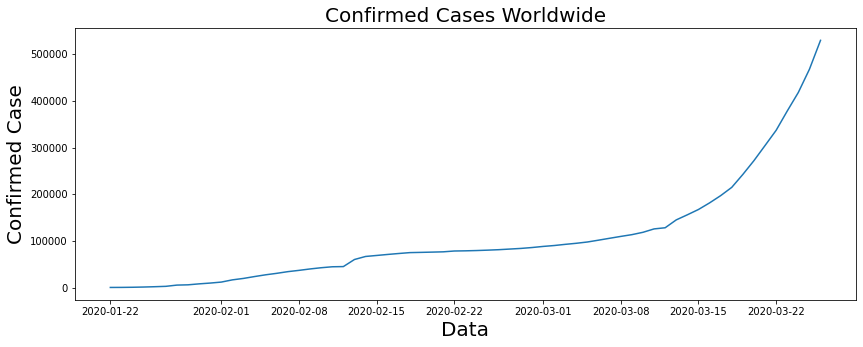

In [4]:
# 全球每日累计确诊人数
n=0
a1=[]
for i in df.columns:
    n+=1
    if n>4:
        a=df[i].sum()
        a1.append(a)
df_2=pd.DataFrame({'world_sum':a1})

# 设置索引，以day为频率
df_2.index=pd.date_range('20200122','20200326',freq='D')
# 画全球每日累计确诊人数趋势图
plt.figure(figsize=(14,5))
plt.xlabel('Data', size=20)
plt.ylabel('Confirmed Case', size=20)
plt.title('Confirmed Cases Worldwide',size=20)
plt.plot(df_2)

In [5]:
# 一阶差分，算出全球每日新增确诊人数
total=df_2
total_diff1 =total.diff(1)
# 补上1月22日的数据
total_diff1['world_sum'][0]=total['world_sum'][0]
total_diff1.head()

,world_sum
2020-01-22,555.0
2020-01-23,99.0
2020-01-24,287.0
2020-01-25,493.0
2020-01-26,684.0


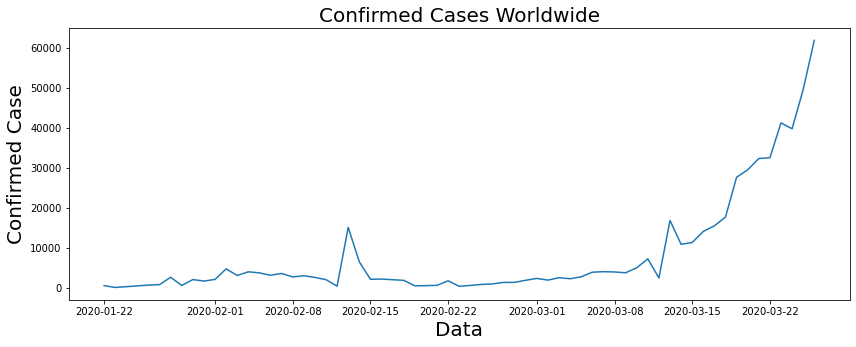

In [6]:
# 画全球每日新增确诊数量趋势图，数据不是平稳数据
plt.figure(figsize=(14,5))
plt.xlabel('Data', size=20)
plt.ylabel('Confirmed Case', size=20)
plt.title('Confirmed Cases Worldwide',size=20)
total_diff1.index = pd.date_range(start_date,p_date, freq='D')
plt.plot(total_diff1)

# 从全球每日新增确诊数量趋势图可知，该数据不是平稳数据。 这里选择取对数的方式进行处理。

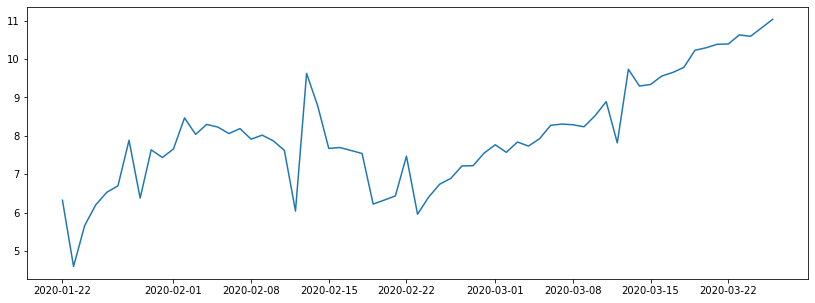

In [7]:
# 对数据进行取对数
plt.figure(figsize=(14,5))
aa=[]
for i in total_diff1['world_sum']:
    aa.append(math.log(i))   
total_log=pd.DataFrame({'world_sum':aa})

total_log.index = pd.date_range(start_date,p_date, freq='D')
plt.plot(total_log)

In [8]:
# 截取训练集和测试集数据
x_train=total_log[:60]
y_test=total_log[60:]
y_test

,world_sum
2020-03-22,10.390748
2020-03-23,10.628182
2020-03-24,10.591873
2020-03-25,10.811907
2020-03-26,11.033889


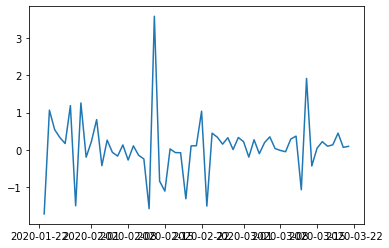

In [9]:
# 再进行一阶差分，观察数据趋势
total_diff2=x_train.diff()
plt.plot(total_diff2)

# 一阶差分之后的时序图看起来已经平稳，但为了更加严谨的确认数据情况，这里用ADF检验，再次验证数据是否平稳。

In [10]:
# ADF检验，验证是否为平稳数据
total_diff2=total_diff2[1:]
total_3=total_diff2['world_sum']
print('数据ADF检验：',sm.tsa.stattools.adfuller(total_3))

数据ADF检验： (-8.560311949735894, 8.731427484994412e-14, 1, 57, {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}, 101.85546146321535)


# ADF的值为-8比-3（1%置信区间的值）还小，说明置信度大于 99%，数据为平稳数据。
# 接着，画自相关和偏自相关图，初步确定p和q的数值。

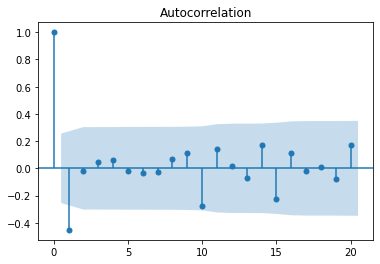

In [11]:
# 画自相关图，估计p的值.p可选1
fig = sm.graphics.tsa.plot_acf(total_diff2,lags=20)

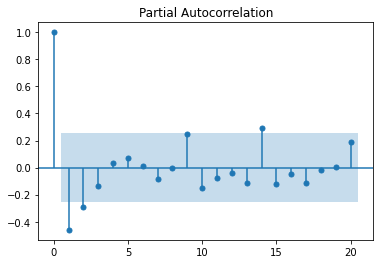

In [12]:
# 画偏自相关图，估计q的值。q可选1,2
fig = sm.graphics.tsa.plot_pacf(total_diff2,lags=20)

In [13]:
# ARIMA（p,d,q）模型选择
# p可选1；q可选1,2
# ARIMA（2,1,0）模型为最优，值最小

# ARIMA（1,1,0）模型
arima_mod10 = sm.tsa.ARIMA(x_train,(1,1,0)).fit()
print(arima_mod10.aic,arima_mod10.bic,arima_mod10.hqic)

# ARIMA（2,1,0）模型
arima_mod20 = sm.tsa.ARIMA(x_train,(2,1,0)).fit()
print(arima_mod20.aic,arima_mod20.bic,arima_mod20.hqic)

# ARIMA（2,1,2）模型
arima_mod22 = sm.tsa.ARIMA(x_train,(2,1,2)).fit()
print(arima_mod22.aic,arima_mod22.bic,arima_mod22.hqic)

# ARIMA（2,1,1）模型
arima_mod21 = sm.tsa.ARIMA(x_train,(2,1,1)).fit()
print(arima_mod21.aic,arima_mod21.bic,arima_mod21.hqic)


135.25753928254878 141.49015161426593 137.69049871370245
132.02219331989417 140.33234309551705 135.26613922809906
134.46829845988114 146.93352312331547 139.3342173221885
133.50062488727968 143.88831210680829 137.5555572725358


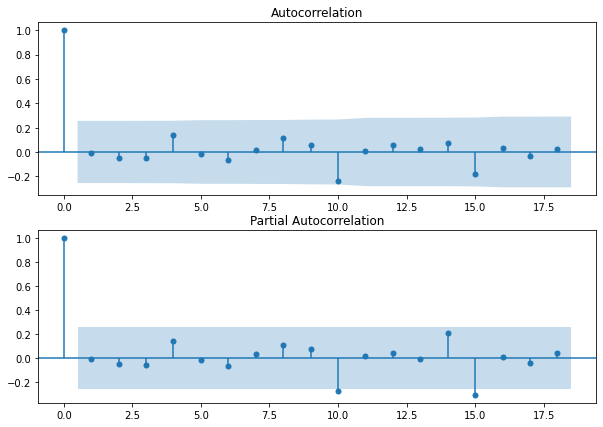

In [14]:
# 模型检验,检验残差序列
arima_mod=arima_mod20
resid = arima_mod.resid
fig = plt.figure(figsize=(10,7))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(),ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid,ax=ax2)

# 残差的ACF和PACF图，可以看到序列残差基本为白噪声。为了确保模型的可行性，继续用DW检验、Ljung-Box检验来验证。

In [15]:
# DW检验。
print(sm.stats.durbin_watson(arima_mod.resid.values))

1.9076390302256914


# 当DW值显著的接近于0或４时，则存在自相关性，而接近于２时，则近乎不存在自相关性。小于2则为正相关，大于2为负相关。
# DW检验结果显示数值接近2，所以相关性弱，残差序列不存在自相关性，模型效果较好。

In [16]:
# Ljung-Box检验（LB检验，判断时间序列是否存在滞后相关）也叫Q检验
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data =np.c_[range(1,len(r)), r[1:], q, p][:20]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0  -0.009778   0.005933  0.938604
2.0  -0.045992   0.139489  0.932632
3.0  -0.052635   0.317537  0.956697
4.0   0.138628   1.575073  0.813265
5.0  -0.014654   1.589385  0.902530
6.0  -0.066780   1.892217  0.929340
7.0   0.019092   1.917445  0.964268
8.0   0.114340   2.840035  0.943991
9.0   0.058698   3.088036  0.960702
10.0 -0.240544   7.337888  0.693207
11.0  0.010466   7.346101  0.770403
12.0  0.060191   7.623531  0.813815
13.0  0.026960   7.680398  0.863781
14.0  0.071752   8.092155  0.884470
15.0 -0.182559  10.818218  0.765371
16.0  0.031705  10.902349  0.815472
17.0 -0.031948  10.989813  0.857093
18.0  0.023092  11.036620  0.892796
19.0 -0.065298  11.420260  0.908891
20.0  0.082670  12.050944  0.914311


# LB检验中prob值均大于0.05，所以残差序列不存在自相关性

2020-03-22    10.463928
2020-03-23    10.542781
2020-03-24    10.625492
2020-03-25    10.705920
2020-03-26    10.786611
Freq: D, dtype: float64


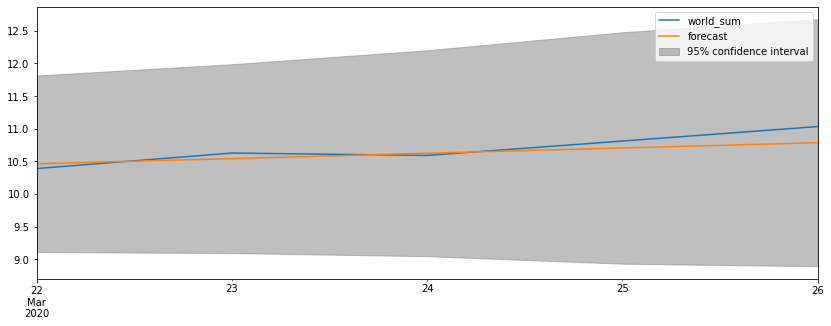

In [17]:
# 模型预测
# 取对数之后的数据
pre = arima_mod.predict(s_date,p_date,typ='levels')
print(pre)

# 实际值和预测值的对比图
fig, ax = plt.subplots(figsize=(14,5))
ax =y_test.plot(ax=ax)
fig = arima_mod.plot_predict(s_date,p_date,dynamic=True, ax=ax,plot_insample=False)

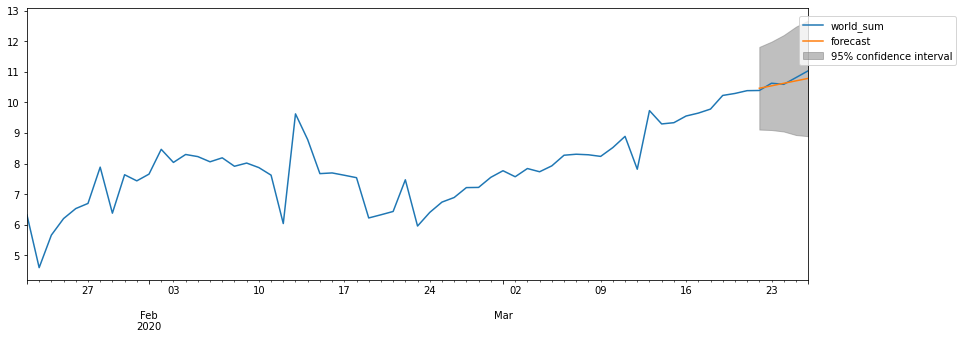

In [18]:
# 实际值和预测值的完整对比图
fig, ax = plt.subplots(figsize=(14,5))
ax =total_log.plot(ax=ax)
fig = arima_mod.plot_predict(s_date,p_date,dynamic=True, ax=ax,plot_insample=False)
plt.legend(bbox_to_anchor=(1.2, 1), loc=1, borderaxespad=0.8)

In [19]:
# 将预测的数值进行反对数，算出预测值
pre_1=math.e**(pre)
print(pre_1)

2020-03-22    35028.882858
2020-03-23    37902.836564
2020-03-24    41171.093182
2020-03-25    44619.198563
2020-03-26    48368.832729
Freq: D, dtype: float64


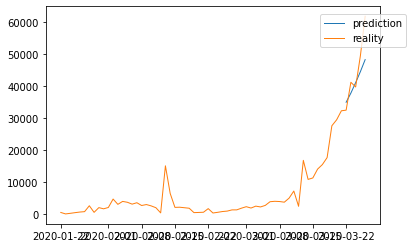

In [20]:
# 真实值和预测值的完整对比图
plt.plot(pre_1,"-",label="prediction",lw=1)  #"-"指将两点之间用线连起来
plt.plot(total_diff1,"-",label="reality",lw=1)
plt.legend(bbox_to_anchor=(1.1, 1), loc=1, borderaxespad=0.8)
plt.rcParams['figure.figsize'] = (15,5)

In [21]:
# 整合数据和算出平均预测精确度
df_end=pd.DataFrame({'world_sum':total_diff1['world_sum']})
df_end.index = pd.date_range('20200122','20200326', freq='D')
df_end['prediction']=pd.DataFrame(pre_1)
df_end['Accuracy']=1-(abs(df_end['world_sum']-df_end['prediction'])/df_end['world_sum'])

pc=((1-abs(df_end['world_sum']-df_end['prediction'])/df_end['world_sum']).mean())
print("平均预测精度:%0.2f%%"%(pc*100))

df_end.loc[df_end['Accuracy'].isnull()==False,'平均预测精度']=("%.2f%%"%(pc*100))
df_end.loc[df_end['平均预测精度'].isnull()==True,'平均预测精度']=''

df_end[-7:]

平均预测精度:89.77%


,world_sum,prediction,Accuracy,平均预测精度
2020-03-20,29535.0,NaN,NaN,
2020-03-21,32361.0,NaN,NaN,
2020-03-22,32557.0,35028.882858,0.924075,89.77%
2020-03-23,41282.0,37902.836564,0.918144,89.77%
2020-03-24,39810.0,41171.093182,0.965810,89.77%
2020-03-25,49608.0,44619.198563,0.899436,89.77%
2020-03-26,61938.0,48368.832729,0.780923,89.77%


# 2020/03/22-2020/03/26的预测值和实际值的对比中，预测精确度最高为96.58%，最低为78.09%，平均预测精确度为89.77%。说明该模型预测效果还不错。